<a href="https://colab.research.google.com/github/ReginaDivaDharma/ebays-reviews-sentiment-analysis/blob/main/SentimentAnalysisBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
import seaborn as sns
from wordcloud import WordCloud

import nltk
import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data  = pd.read_csv('/content/ebay_reviews.csv')
data.head(5)

,category,review title,review content,rating
0,Headsets,Wireless gaming headset,This gaming headset ticks all the boxes # look...,5
1,Headsets,"Good for those with a big head, low budget","Easy setup, rated for 6 hours battery but mine...",3
2,Headsets,MezumiWireless Gaming Headset,I originally bought this wireless headset for ...,5
3,Headsets,HW- S2 great headset.,"This is my 2nd Mezumi headset, It kills the fi...",5
4,Headsets,BEST HEADPHONES I'VE PURCHASED IN MY ENTIRE LIFE,This is probably the best headset I've purchas...,5


In [ ]:
data.dtypes

category          object
review title      object
review content    object
rating             int64
dtype: object

In [ ]:
# Search for missing values
data.isnull().sum()

category          0
review title      0
review content    0
rating            0
dtype: int64

In [ ]:
# map ratings 1,2,3 to 0 (Negative) and 4,5 to 1 (Positive)
sentimentScore = {1: 0, 2: 0, 3: 0, 4: 1, 5:1}
sentiment = {0: 'Negative', 1: 'Positive'}

#Mapping
data['sentimentScore'] = data['rating'].map(sentimentScore)
data['sentiment'] = data['sentimentScore'].map(sentiment)
data.head()

,category,review title,review content,rating,sentimentScore,sentiment
0,Headsets,Wireless gaming headset,This gaming headset ticks all the boxes # look...,5,1,Positive
1,Headsets,"Good for those with a big head, low budget","Easy setup, rated for 6 hours battery but mine...",3,0,Negative
2,Headsets,MezumiWireless Gaming Headset,I originally bought this wireless headset for ...,5,1,Positive
3,Headsets,HW- S2 great headset.,"This is my 2nd Mezumi headset, It kills the fi...",5,1,Positive
4,Headsets,BEST HEADPHONES I'VE PURCHASED IN MY ENTIRE LIFE,This is probably the best headset I've purchas...,5,1,Positive


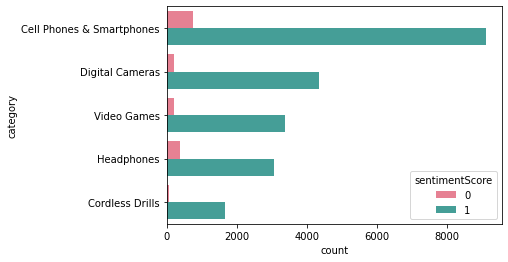

In [ ]:
# Cell phones and Smartphones are the product that gets the most positive review
sns.countplot(data=data, y='category', hue='sentimentScore', palette = "husl",order=data.category.value_counts().iloc[:5].index)

In [ ]:
# Get words used in positive review
positiveWords = pd.Series(' '.join(data[data['sentiment'] == 'Positive']['review content']).split())

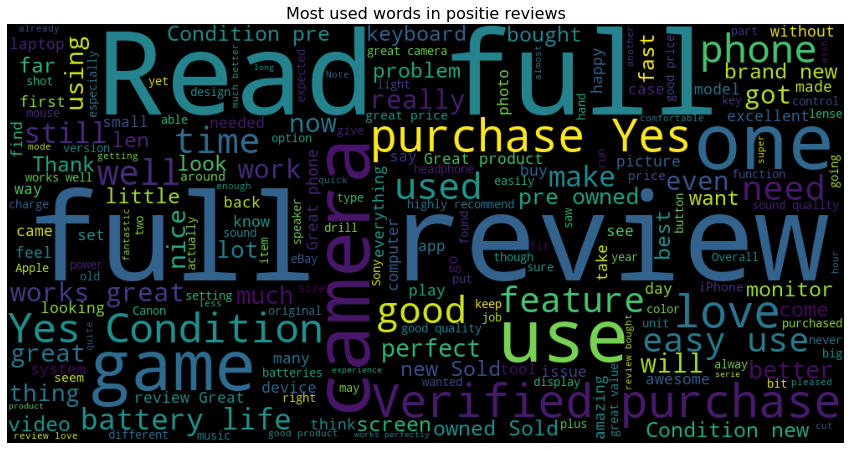

In [ ]:
# Plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(positiveWords))

plt.figure(figsize = (15,8))

plt.imshow(wordcloud)
plt.title("Most used words in positie reviews", size = 16)

plt.axis("off")
plt.show()

In [ ]:
# Get words used in negative reviews
negativeWords = pd.Series(' '.join(data[data['sentiment'] == 'Negative']['review content']).split())

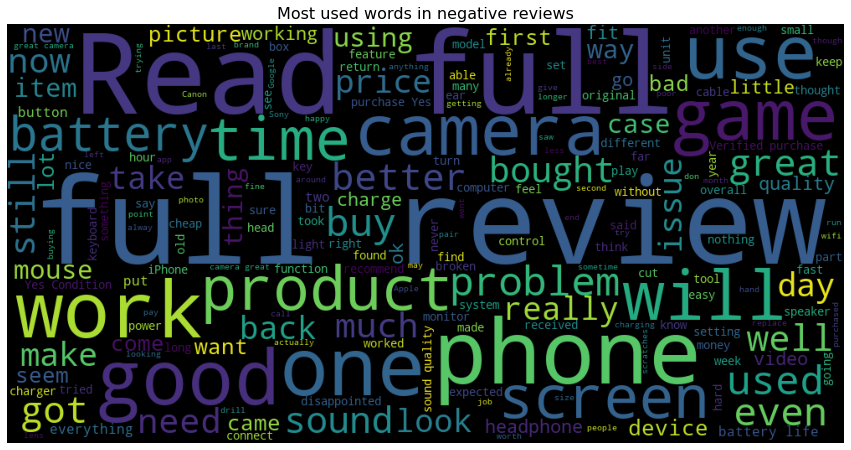

In [ ]:
# Plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(negativeWords))

plt.figure(figsize = (15,8))

plt.imshow(wordcloud)
plt.title("Most used words in negative reviews", size = 16)

plt.axis("off")
plt.show()

In [ ]:
# Text Processing

#1 Clean text Function
def cleanText(text:str):
  text = str(text)
  text = text.lower()
  text = text.strip()

  text = re.sub(' \d+', ' ', text)
  text = re.compile('<.*?>').sub(' ', text)
  text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
  text = re.sub('\s+', ' ', text)

  text = text.strip()

  return text

In [ ]:
#2 Remove Stopwords
def removeStopwords(text:str):
    text = str(text)
    filteredSentence = []

    stopWords = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        if w not in stopWords:
            filteredSentence.append(w)
    text = " ".join(filteredSentence)

    return text

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
#3 Lemmatize Function
# If we are not satisfied with the result of stemming, we can use the Lemmatization instead.
def lemmatize(text:str):
    text = str(text)

    # Initialize the lemmatizer
    wl = WordNetLemmatizer()

    lemmatizedSentence = []

    # Tokenize the sentence
    words = word_tokenize(text)
    # Get position tags
    wordPosTags = nltk.pos_tag(words)
    # Map the position tag and lemmatize the word/token
    for idx, tag in enumerate(wordPosTags):
        lemmatizedSentence.append(wl.lemmatize(tag[0], get_wordnet_pos(tag[1])))

    lemmatizedText = " ".join(lemmatizedSentence)

    return lemmatizedText

In [ ]:
# Apply three of them to our dataset
# Clean text
data['text'] = data['review content'].apply(cleanText)

# Remove Stopwords
data['text'] = data['text'].apply(removeStopwords)

# Lemmatize
data['text'] = data['text'].apply(lemmatize)

In [ ]:
# Test
import random
idx = random.choice(range(len(data)))

print(f"The original text: \n{data['review content'].iloc[idx]}\n")
print(f"The cleaned text: \n{data['text'].iloc[idx]}")

The original text: 
Very nice trimmers very light easy to hold 

The cleaned text: 
very nice trimmer very light easy hold


In [ ]:
data.to_csv('cleanedDataset.csv', index = False)

In [ ]:
# New dataframe
data = pd.read_csv('cleanedDataset.csv')

In [ ]:
# Data type
data.dtypes

category          object
review title      object
review content    object
rating             int64
sentimentScore     int64
sentiment         object
text              object
dtype: object

In [ ]:
# Check if there are some missing values
data[data['text'].isnull()]

,category,review title,review content,rating,sentimentScore,sentiment,text
4668,Cell Phones & Smartphones,Very good,A+++++++,5,1,Positive,NaN
5874,Cell Phones & Smartphones,brand new - flawless,A++++++++,5,1,Positive,NaN
7170,"Cases, Covers & Skins",Great product,+++++++++,5,1,Positive,NaN
7984,Cell Phones & Smartphones,Very pleased,A+++++,5,1,Positive,NaN
8297,Smart Watches,Good watch,A+++,5,1,Positive,NaN
9141,Cell Phones & Smartphones,Love,It,5,1,Positive,NaN
10309,Other Plush Bears,awsome,a+++++++,5,1,Positive,NaN
11986,Clippers & Trimmers,Perfect,A+++!!!,5,1,Positive,NaN
13154,Digital Cameras,A++,A++,5,1,Positive,NaN
13897,Digital Cameras,Vert good,A+,5,1,Positive,NaN


In [ ]:
# drop null values
data.dropna(inplace = True)
data.isnull().sum()

category          0
review title      0
review content    0
rating            0
sentimentScore    0
sentiment         0
text              0
dtype: int64

In [ ]:
# TF-IDF
# a technique to quantify words in a set of documents.
vect = TfidfVectorizer(max_features=700)
vect.fit(data['text'])
features = vect.transform(data['text'])

features.toarray()


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.05358049, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
tfIdf = pd.DataFrame(features.toarray(), columns = vect.get_feature_names())
tfIdf.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,10,ability,able,about,absolutely,accessory,action,actually,adapter,add,...,wouldn,wrong,xbox,year,yes,yet,you,your,youtube,zoom
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.154917,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.052039,0.0,0.0,0.0,0.073293,0.0,0.071563,...,0.0,0.0,0.1753,0.0,0.0,0.0,0.226306,0.053580,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.117139,0.0,0.000000,...,0.0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.085635,0.0,0.0


In [ ]:
# Split dataset
x_train, x_test, y_train, y_test = train_test_split(tfIdf, data['sentimentScore'], test_size=0.2, random_state=42)


In [ ]:
yy = pd.DataFrame(y_train)
train_data = pd.concat([x_train, yy], axis = 1)
train_data.head()

,10,ability,able,about,absolutely,accessory,action,actually,adapter,add,...,wrong,xbox,year,yes,yet,you,your,youtube,zoom,sentimentScore
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0000,0.0,0.0,0.0,0.154917,0.00000,0.0,0.0,1.0
2,0.0,0.0,0.0,0.052039,0.0,0.0,0.0,0.073293,0.0,0.071563,...,0.0,0.1753,0.0,0.0,0.0,0.226306,0.05358,0.0,0.0,1.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,1.0
5,0.0,0.0,0.0,0.175829,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0000,0.0,0.0,0.0,0.063720,0.00000,0.0,0.0,1.0
6,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,1.0


In [ ]:
# Oversampling
# selecting examples from the minority class, with replacement, and adding them to the training dataset
train_data['sentimentScore'].value_counts()

1.0    33151
0.0     2622
Name: sentimentScore, dtype: int64

In [ ]:
target_count = train_data['sentimentScore'].value_counts()
negativeClass = train_data[train_data['sentimentScore'] == 0]
positiveClass = train_data[train_data['sentimentScore'] == 1]

negativeOver = negativeClass.sample(target_count[1], replace=True)

df_train_over = pd.concat([positiveClass, negativeOver], axis=0)
df_train_over = shuffle(df_train_over)
df_train_over.head()

,10,ability,able,about,absolutely,accessory,action,actually,adapter,add,...,wrong,xbox,year,yes,yet,you,your,youtube,zoom,sentimentScore
22328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
38976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.091944,0.0,0.202107,0.0,1.0
11339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0
36288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [ ]:
# drop null values
df_train_over.dropna(inplace=True)

In [ ]:
x_train = df_train_over.iloc[:,:-1]
y_train = df_train_over['sentimentScore']

In [ ]:
# Model
def modeling(Model, xTrain = x_train, xTest = x_test):
    # Instantiate the classifier: model
    model = Model

    # Fitting classifier to the Training set (all features)
    model.fit(xTrain, y_train)

    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(xTest)

    # Assign f1 score to a variable
    print(classification_report(y_test, y_pred))
    print ('AUC ',roc_auc_score(y_test, y_pred))
    #cm = confusion_matrix(y_test, y_pred)
    confusion_matrix = pd.crosstab(index=y_test, columns=np.round(y_pred), rownames=['Actual'], colnames=['Predictions']).astype(int)
    plt.figure(figsize = (8,8))

    sns.heatmap(confusion_matrix, annot=True,annot_kws={"fontsize":14}, fmt='.2f', cmap='Greens').set_title('Confusion Matrix')

              precision    recall  f1-score   support

           0       0.14      0.72      0.23       692
           1       0.96      0.62      0.76      8252

    accuracy                           0.63      8944
   macro avg       0.55      0.67      0.49      8944
weighted avg       0.90      0.63      0.72      8944

AUC  0.6727673655572025


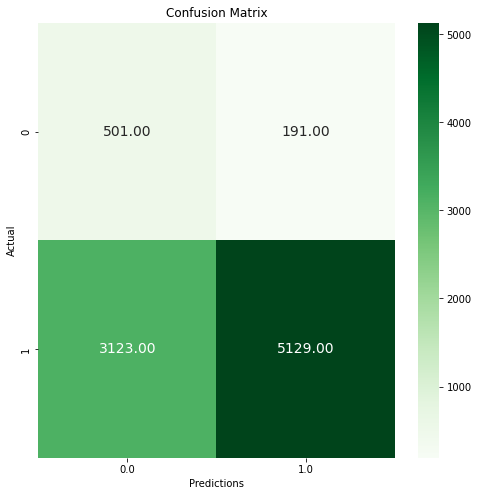

In [ ]:
# Naive Bayes
modeling(MultinomialNB())